In [23]:
%pip install pandas
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Generate x_train, x_test, y_train, y_test

In [24]:
# Generate X

from PIL import Image
import numpy as np
import glob

def get_list_of_files(source_path:str) -> list[str]:
	train_files= glob.glob(source_path+'train*.png')
	train_files = [(int(i[len(source_path)+5:-4]), i) for i in glob.glob(source_path+'train*.png')]
	train_files.sort()
	return [i[1] for i in train_files]

pngs = get_list_of_files('../../input/images/2000-samples/')
# pngs = get_list_of_files('../../input/images/10000-samples/')
# pngs = get_list_of_files('../../input/images/train_png/')
x = np.array([np.asarray(Image.open(i))[:,:,:3] for i in pngs])
print(x.shape)

x = x.reshape(x.shape[0], -1)
x.shape

(2000, 255, 255, 3)


(2000, 195075)

In [25]:
# Generate Y

import pandas

def y_int_to_str(y:int) -> str:
	match y:
		case 0: return "No Whale"
		case 1: return "Whale Present"
		case _: raise ValueError("Unrecognized label")
print(f"1 -> {y_int_to_str(1)}")

y = pandas.read_csv('../../input/audio/data/train.csv')
y = y["label"][:len(x)]
y.shape

1 -> Whale Present


(2000,)

In [26]:
# Generate Train and Test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
	x,
	y,
	test_size=0.33,
	random_state=4,
	stratify=y
)

print(f"""
x_train\t is \t{x_train.shape}
x_test\t is \t{x_test.shape}
y_train\t is \t{y_train.shape}
y_test\t is \t{y_test.shape}

x_train takes up {x_train.nbytes/1e9:,.2f} GB of memory
""")



x_train	 is 	(1340, 195075)
x_test	 is 	(660, 195075)
y_train	 is 	(1340,)
y_test	 is 	(660,)

x_train takes up 0.26 GB of memory



# K-NN

## Basic K-NN

In [27]:
# Create Model, Save Model, and Find Accuracy

from sklearn.neighbors import KNeighborsClassifier
import os
import pickle

models_folder = 'models'
n_neighbors=5

shared_title = f'{n_neighbors}-{len(y)}'
if not os.path.exists(models_folder): os.makedirs(models_folder)

title = f'{shared_title}-NN_simple.pkl'
file = f'{models_folder}/{title}'
if title not in os.listdir(models_folder):
	model = KNeighborsClassifier(
		n_neighbors=n_neighbors,
		n_jobs=-1
	)
	model.fit(
		x_train, 
		y_train
	)
	with open(file, 'wb') as f:
		pickle.dump(model, f)
else:
	with open(file, 'rb') as f: model = pickle.load(f)

title = f'{shared_title}-NN_simple_acc.pkl'
file = f'{models_folder}/{title}'
if title not in os.listdir(models_folder):
	acc = model.score(
		x_test, 
		y_test
	)
	# pickle accuracy
	with open(file, 'w') as f:
		f.write(str(acc))
else:
	with open(file, 'r') as f: acc = float(f.read())

print("Accuracy: {:.2f}%".format(acc * 100))

title = f'{shared_title}-NN_simple_pred.pkl'
file = f'{models_folder}/{title}'
if title not in os.listdir(models_folder):
	y_pred = model.predict(x_test)
	with open(file, 'wb') as f:
		pickle.dump(y_pred, f)
else:
	with open(file, 'rb') as f: y_pred = pickle.load(f)

Accuracy: 92.42%


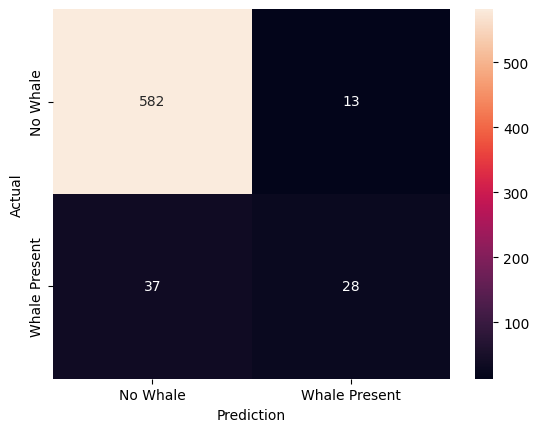

In [28]:
# Confusion Matrix

import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
labels = ['No Whale','Whale Present']

_ = sns.heatmap(
	cm, 
	annot=True,
	fmt='d',
	xticklabels=labels,
	yticklabels=labels
).set(
	xlabel='Prediction',
	ylabel='Actual'
)

## KD-Tree

## Cross-validation to find the best k